With ASTrED, you can choose how much control to take over the input. In this notebook, we'll do everything manually!

What this means is that we provide 1. tokenised; 2. dependency-parsed; 3. word-aligned data to create the
 `AlignedSentences` object that contains all the useful information that we want to gather. Note that this approach
  is _super fast_: we do not need to rely on automatic tools and we can immediately calculate all metrics.

In [1]:
from astred import AlignedSentences, Sentence, Word


In this example, we will align "Sometimes she asks me why I used to call her father Harold ." with the Dutch sentence
 "Soms vraagt ze waarom ik haar vader Harold noemde .". Because we do not want to rely on automatic parsers, we need
 to create the `Word` objects manually. This is easy, though! For each word, you'll need 1. its text (Duh!); 2. the
 index of its parent word (starting from 1, use 0 as the head of the root node); 3. its
 [dependency label](https://universaldependencies.org/u/dep/index.html).

We will first create a list of tuples that contains the information that we need. Then, by means of a list
 comprehension, we create a list of `Word`s and - in one go - we pass that list to the `Sentence` constructor.

Note that we start counting at `1` (`enumerate(..., 1)`). This is very important (and the code will prevent you from
 starting at 0)! The reason is that every `Sentence` has a NULL word at index 0. This word is used as a reference
 alignment point for words that are not aligned. (But do not worry, those alignments do not impact any cross values.)
 The implication is that after an `AlignedSentences` object is created, a NULL word is added to the front of the
 respective `Sentence`s.

In [2]:
# (Text, id of head (0 for root), dependency label)
en_words = [("Sometimes", 3, "advmod"), ("she", 3, "nsubj"), ("asks", 0, "root"), ("me", 3, "obj"), ("why", 7, "advmod"),
            ("I", 7, "nsubj"), ("used", 3, "ccomp"), ("to", 9, "mark"), ("call", 7, "xcomp"), ("her", 11, "nmod"),
            ("father", 9, "obj"), ("Harold", 9, "xcomp"), (".", 3, "punct")]
sent_en = Sentence([Word(id=idx, text=w[0], head=w[1], deprel=w[2]) for idx, w in enumerate(en_words, 1)])

nl_words = [("Soms", 2, "advmod"), ("vraagt", 0, "root"), ("ze", 2, "nsubj"),  ("waarom", 9, "advmod"),
            ("ik", 9, "nsubj"), ("haar", 7, "nmod"), ("vader", 9, "obj"), ("Harold", 9, "xcomp"), ("noemde", 2, "xcomp"),  (".", 2, "punct")]
sent_nl = Sentence([Word(id=idx, text=w[0], head=w[1], deprel=w[2]) for idx, w in enumerate(nl_words, 1)])

In addition to manually creating the `Word`s we also provide the word alignment information in the typical Pharaoh
 format `i-j` where `i` is the index of a source token and `j` the index of the target token that it is aligned with.
 *Important*: even though we started counting at `1` to create the words, the word alignments are still 0-based, as
 usual, meaning that 0 refers to the first actual (non-NULL) word in the sentence. This means that you can easily
 re-use alignments that you retrieved from an alignment tool.

In [3]:
aligns = "0-0 1-2 2-1 4-3 5-4 6-8 7-8 8-8 9-5 10-6 11-7 12-9"
aligned = AlignedSentences(sent_en, sent_nl, word_aligns=aligns)


The `aligned` object has now been created and contains all the information that you need. Here are some examples, but
the other example notebooks may also give you a good idea of what is possible.

In [4]:
# Print the target sentence as text
print(aligned.tgt.text)
# Note that Harold is index 8 because index 0 is now for NULL
print(aligned.tgt[8].text)
print(aligned.tgt[0])

Soms vraagt ze waarom ik haar vader Harold noemde .
Harold
Null(id=0, side=tgt, text=[[NULL]])


You can also easily iterate over sentences as if they were a list of words. Note that we explicitly ask for `Word`s
that are not NULL words. If you want to iterate over all `Word`s, including NULL, then use `for word in aligned.src`.

In [5]:
print("text\tdeprel\tcross\tseq_cross\tsacr_cross\tastred_op")
for word in aligned.src.no_null_words:
	print(word.text, word.deprel, word.cross, word.seq_group.cross, word.sacr_group.cross, word.tree.astred_op, sep="\t")

text	deprel	cross	seq_cross	sacr_cross	astred_op
Sometimes	advmod	0	0	0	match
she	nsubj	1	1	1	match
asks	root	1	1	1	match
me	obj	None	None	None	deletion
why	advmod	0	0	0	match
I	nsubj	0	0	0	match
used	ccomp	3	1	2	match
to	mark	3	1	2	deletion
call	xcomp	3	1	2	deletion
her	nmod	3	1	1	match
father	obj	3	1	1	match
Harold	xcomp	3	1	1	match
.	punct	0	0	0	match


If you are working with Pandas, it is relatively straight-forward to make a DataFrame out of this. Again, this is
 definitely not the only information you can extract, but it serves as an example.

In [6]:
import pandas as pd

df = pd.DataFrame.from_dict({w.text: [w.deprel, w.cross, w.sacr_group.cross, w.num_changes(), w.tree.astred_op]
				   for w in aligned.src.no_null_words},
							orient="index",
							columns=["deprel", "cross", "sacr_cross", "dep_changes", "astred_op"])

# You only need display and HTML for visualisation in Notebooks (and it probably also works by
# just calling `df` at the end of the cell)
df

,deprel,cross,sacr_cross,dep_changes,astred_op
Sometimes,advmod,0.0,0.0,0.0,match
she,nsubj,1.0,1.0,0.0,match
asks,root,1.0,1.0,0.0,match
me,obj,NaN,NaN,NaN,deletion
why,advmod,0.0,0.0,0.0,match
I,nsubj,0.0,0.0,0.0,match
used,ccomp,3.0,2.0,1.0,match
to,mark,3.0,2.0,1.0,deletion
call,xcomp,3.0,2.0,0.0,deletion
her,nmod,3.0,1.0,0.0,match


It is also possible to display the dependency trees. If you are working with Notebooks, you can make use of `display`,
 but then we first need to convert the tree into an NLTK tree with the method `to_string`.

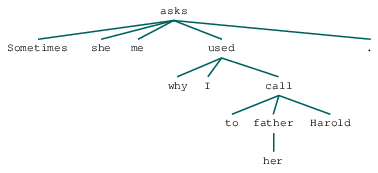

In [7]:
from nltk.tree import Tree as NltkTree
from IPython.display import display

display(NltkTree.fromstring(sent_en.tree.to_string()))

If you are not using a notebook, and just want to show the tree during the execution of your script, you can use
 the class method `Tree` to draw trees. It makes use of NLTKs built-in tree viewer. This may *not* be ideal because it
 halts the execution of the script. That is, as long as the window with the tree is open, your code will not execute
 further. You need to close that window to continue. After you execute the following cell, you will also have to close
 the tree viewer before you can continue.

In [8]:
from astred.tree import Tree

# Uncomment if you want to execute this cell. It will halt the execution of the rest of the notebook.
# Close pop-up window to continue execution.
# Tree.draw_trees(sent_nl.tree)

As said before, when a `Sentence` is passed to `AlignSentences`, it will be changed - particularly because it gets a
 NULL word at the front. This means that `aligned.src` is the same as `sent_en`.

In [9]:
print("Are they the same object?", aligned.src is sent_en)
print("First word in aligned.src:", aligned.src[0])
print("First word in sent_en:", sent_en[0])

Are they the same object? True
First word in aligned.src: Null(id=0, side=src, text=[[NULL]])
First word in sent_en: Null(id=0, side=src, text=[[NULL]])


However, it might be that you do not wish that the initial `Sentence` is modified in-place. If that is the case, you
 can pass `make_copy=True` to the constructor. In that case, a deep copy will be created of the input `Sentence`s
 so that they are not modified in-place. You will now notice that `sent_en` (the original sentence) is not modified.

In [10]:
# Recreate Sentences, which were changed in-place before
sent_en = Sentence([Word(id=idx, text=w[0], head=w[1], deprel=w[2]) for idx, w in enumerate(en_words, 1)])
sent_nl = Sentence([Word(id=idx, text=w[0], head=w[1], deprel=w[2]) for idx, w in enumerate(nl_words, 1)])

aligned = AlignedSentences(sent_en, sent_nl, word_aligns=aligns, make_copies=True)

print("Are they the same object?", aligned.src is sent_en)
print("First word in aligned.src:", aligned.src[0])
print("First word in sent_en:", sent_en[0])

Are they the same object? False
First word in aligned.src: Null(id=0, side=src, text=[[NULL]])
First word in sent_en: Word(id=1, side=None, text=Sometimes)
